# ex1: Inverse Filtering

In [128]:
from scipy.fft import fft2, fftshift
from pathlib import Path
import numpy as np
import skimage
import matplotlib.pyplot as plt

In [129]:
ASSETS_FOLDER_PATH = "./assets"
OUTPUT_FOLDER_PATH = "."

In [130]:
Path(OUTPUT_FOLDER_PATH).mkdir(parents=True, exist_ok=True)

Cargamos la imagen

In [131]:
my_image = skimage.io.imread(fname=f"{ASSETS_FOLDER_PATH}/lena_gray.tif")
# my_image = skimage.io.imread(fname=f"{ASSETS_FOLDER_PATH}/clown.jpg")

In [132]:
imsize = my_image.shape

Definimos las funciones a utilizar:

In [133]:
def fft2c(x: np.ndarray) -> np.ndarray:
    return fftshift(fft2(fftshift(x)))

In [134]:
def ifft2c(x: np.ndarray) -> np.ndarray:
    return fftshift(np.fft.ifft2(fftshift(x)))

In [135]:
def lowpass_kernel(kernel_size, image_dimensions):
    height, width = image_dimensions
    kernel = np.zeros((height, width))
    center_x, center_y = (height // 2, width // 2)
    kernel[center_x - kernel_size // 2: center_x + kernel_size // 2 + 1,
           center_y - kernel_size // 2: center_y + kernel_size // 2 + 1] = 1 / (kernel_size ** 2)
    return kernel

In [136]:
def plot_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.title(title)
    plt.show()

In [137]:
def plot_images(img1, title1, img2, title2):
    fig = plt.figure(figsize=(6, 7))
    
    fig.add_subplot(1, 2, 1)
    plt.imshow(img1, cmap='gray')
    plt.axis('off')
    plt.title(title1)

    fig.add_subplot(1, 2, 2)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    plt.title(title2)

    plt.subplots_adjust(wspace=0.05, hspace=0)
    plt.show()

In [138]:
def mse(original, variation):
    return (original - variation).var()

## Blur

Calculamos el kernel:

In [139]:
gks = 80
gk = np.exp(-(np.arange(max(imsize)) - max(imsize) // 2) ** 2 / (2 * gks ** 2))
gauss_kernel = np.outer(gk, gk)

gauss_kernel = gauss_kernel[
    (max(imsize) - imsize[0]) // 2:(max(imsize) - imsize[0]) // 2 + imsize[0],
    (max(imsize) - imsize[1]) // 2:(max(imsize) - imsize[1]) // 2 + imsize[1]
]

In [140]:
# blur_kernel = gauss_kernel
blur_kernel = lowpass_kernel(5, imsize)

Obtenemos la imagen con blur:

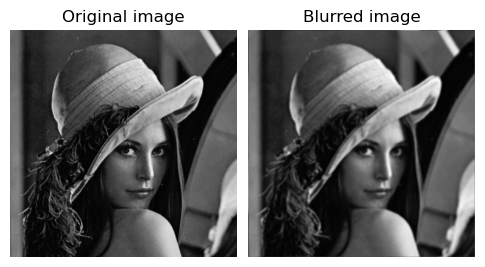

In [141]:
blurred_image = np.abs(ifft2c(fft2c(my_image) * fft2c(blur_kernel)))
plot_images(my_image, 'Original image', blurred_image, 'Blurred image')

Aplicando la operación inversa sobre la imagen borrosa:

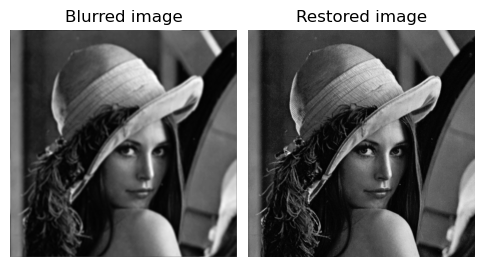

mse: 1.2837268724024443e-21


In [149]:
restored_image_blur = np.abs(ifft2c(fft2c(blurred_image) / fft2c(blur_kernel)))
plot_images(blurred_image, 'Blurred image', restored_image_blur, 'Restored image')
print(f"mse: {mse(my_image, restored_image_blur)}")

## Blur + Noise

Definimos el signal-to-noise ratio:

In [143]:
SNR_dB = 10

Calculamos la desviación estándar de la imagen borrosa para el ruido:

In [144]:
sigma_blurred_image = np.std(blurred_image)
sigma_noise = np.sqrt((sigma_blurred_image ** 2) * (10 ** (-SNR_dB / 10)))
noise = np.random.normal(0, sigma_noise, (imsize[0], imsize[1]))

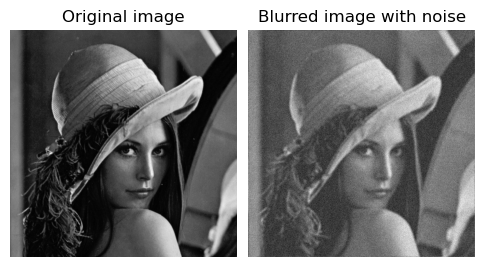

In [145]:
blurred_noise_image = blurred_image + noise
plot_images(my_image, 'Original image', blurred_noise_image, 'Blurred image with noise')

Aplicando la operación inversa:

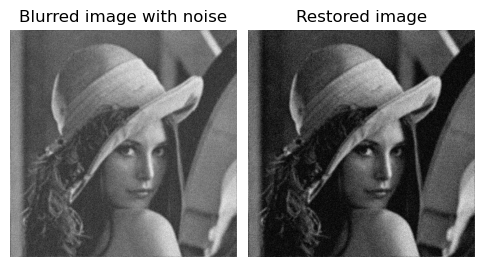

mse: 271.97486643975793


In [150]:
restored_image_blur_noise = np.abs(ifft2c(fft2c(blurred_noise_image)))
plot_images(blurred_noise_image, 'Blurred image with noise', restored_image_blur_noise, 'Restored image')
print(f"mse: {mse(my_image, restored_image_blur_noise)}")

# ex2: Wiener

Definimos un filtro de Wiener:

In [156]:
def wiener_filter_restoration(blurred_image, blur_kernel, noise):
    blurred_fft = fft2c(blurred_image)
    kernel_fft = fft2c(blur_kernel)
    noise_psd = np.square(np.abs(fft2c(noise)))
    wiener_filter = np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + noise_psd / np.square(np.abs(blurred_fft)))
    restored_fft = wiener_filter * blurred_fft
    restored_image = np.abs(ifft2c(restored_fft))
    return restored_image

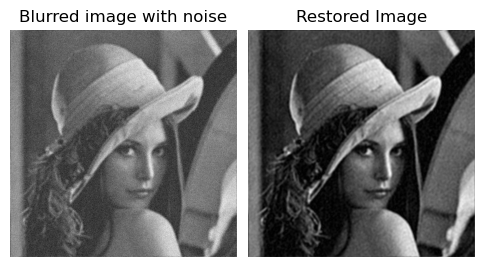

mse: 69.15799073249357


In [157]:
restored_image_wiener = wiener_filter_restoration(blurred_noise_image, blur_kernel, noise)
plot_images(blurred_noise_image, 'Blurred image with noise', restored_image_wiener, 'Restored Image')
print(f"mse: {mse(my_image, restored_image_wiener)}")